<a href="https://colab.research.google.com/github/carlosmvond/modelos_predictivos/blob/main/MP_Clase_24sept2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


En este código vamos a calibrar una regresión no-lineal usando inferencia bayesiana.




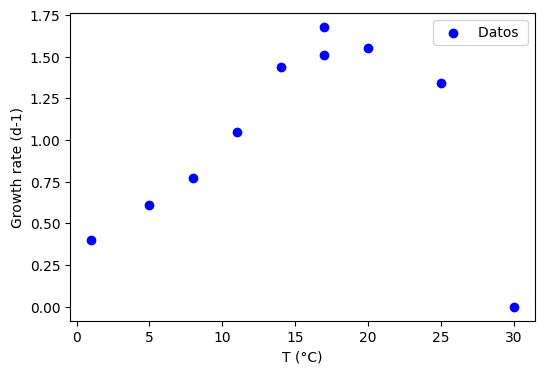

In [109]:

#DATOS

#!pip install pymc     # Para instalar PyMC!


import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# 1. Generar datos a partir de una regresión lineal y agregar error
np.random.seed(42)

T = np.array([
    1,
    5,
    8,
    11,
    14,
    17,
    17,
    20,
    25,
    30
])

# Datos de tasa de crecimiento
mu_obs = np.array([
    0.4,
    0.61,
    0.77,
    1.05,
    1.44,
    1.68,
    1.51,
    1.55,
    1.34,
    0
])

# Crear un gráfico
plt.figure(figsize=(6, 4))

# Graficar los puntos originales sin los outliers
plt.scatter(T, mu_obs, color='blue', label='Datos ')

# Añadir etiquetas y título
plt.xlabel('T (°C)')
plt.ylabel('Growth rate (d-1)')
plt.legend()

# Mostrar el gráfico
plt.show()



Ahora ajustamos la regresión  utilizando PyMC.

In [107]:
#MODELO BAYESIANO


# 2. Ajustar una regresión lineal usando PyMC
with pm.Model() as model:

    Tmin=pm.Uniform('Tmin', lower=-100, upper=5)
    Topt=pm.Uniform('Topt', lower=Tmin, upper=30)
    Tmax=pm.Uniform('Tmax', lower=Topt, upper=35)
    mu_opt=pm.Normal('mu_opt', mu=1.6, sigma=0.1)
    sigma = pm.HalfNormal('sigma', sigma=0.5)

    phi = ((T - Tmax) * (T - Tmin) ** 2)/((Topt - Tmin) * ((Topt - Tmin) * (T - Topt) - (Topt - Tmax) * (Topt + Tmin - 2 * T)))

    model = pm.math.switch(T < Tmin, 0,
                        pm.math.switch(T <= Tmax,
                                        mu_opt * ((T - Tmax) * (T - Tmin)**2) / ((Topt - Tmin) * ((Topt - Tmin) * (T - Topt) - (Topt - Tmax) * (Topt + Tmin - 2 * T))),
                                        0))

    # Usar la distribución normal para las observaciones
    pm.Normal('y_obs', mu=model, sigma=sigma, observed=mu_obs)

    trace = pm.sample(500, tune=500, return_inferencedata=True, chains=2, cores=2, target_accept=0.95)



Output()

<ipython-input-108-d70ab38fa907>:47: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=0.95)  # Intervalos creíbles del 95%


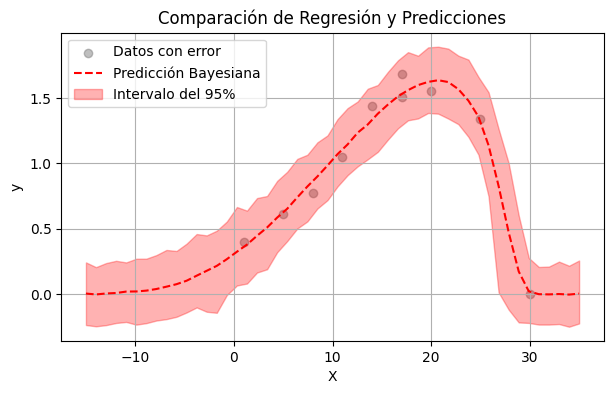

          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Tmax    28.891  1.012    26.844     30.494      0.056    0.040     380.0   
Tmin   -10.942  4.768   -18.177     -3.790      0.465    0.337     227.0   
Topt    20.549  0.891    18.862     22.123      0.062    0.046     325.0   
mu_opt   1.641  0.058     1.522      1.766      0.003    0.002     420.0   
sigma    0.110  0.040     0.055      0.193      0.003    0.002     277.0   

        ess_tail  r_hat  
Tmax       346.0   1.01  
Tmin       123.0   1.01  
Topt       168.0   1.00  
mu_opt     443.0   1.00  
sigma      194.0   1.01  


In [108]:


# HDI (Intervalo de Densidad Alta) para la regresión bayesiana
Tmin_samples = trace.posterior['Tmin'].values.flatten()
Topt_samples = trace.posterior['Topt'].values.flatten()
Tmax_samples = trace.posterior['Tmax'].values.flatten()
mu_opt_samples = trace.posterior['mu_opt'].values.flatten()

sigma_samples = trace.posterior['sigma'].values.flatten()




#GRÁFICOS

def evaluate_mu(T, Tmin, Topt, Tmax, mu_opt):
    # Inicializar un array para mu
    mu_values = np.zeros_like(T)

    # Calcular mu para cada elemento de T
    for i, t in enumerate(T):
        if t < Tmin:
            mu_values[i] = 0
        elif Tmin <= t <= Tmax:
            phi = ((t - Tmax) * (t - Tmin) ** 2) / (
                (Topt - Tmin) * ((Topt - Tmin) * (t - Topt) - (Topt - Tmax) * (Topt + Tmin - 2 * t))
            )
            mu_values[i] = mu_opt * phi
        else:  # t > Tmax
            mu_values[i] = 0

    return mu_values

# 3. Crear gráficos

T_plot=np.linspace(-15, 35, 50)

y_pred_samples = np.empty((len(Tmin_samples), len(T_plot)))


for i in range(len(Tmin_samples)):
    # Calcular el parámetro de ubicación (mu) para la muestra actual
    mu = evaluate_mu(T_plot, Tmin_samples[i], Topt_samples[i], Tmax_samples[i], mu_opt_samples[i])
    # Generar predicciones usando la distribución normal
    y_pred_samples[i] = np.random.normal(loc=mu, scale=sigma_samples[i], size=len(T_plot))

# 4. Calcular la media y los intervalos creíbles para las predicciones
y_pred_mean = y_pred_samples.mean(axis=0)  # Media de las muestras predichas
y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=0.95)  # Intervalos creíbles del 95%

# Graficar los resultados
plt.figure(figsize=(7, 4))

# Graficar datos originales con errores
plt.scatter(T, mu_obs, label='Datos con error', color='gray', alpha=0.5)

# Línea de regresión bayesiana (predicción media)
plt.plot(T_plot, y_pred_mean, label='Predicción Bayesiana', color='red', linestyle='--')

# Intervalos creíbles para las predicciones bayesianas
plt.fill_between(T_plot, y_pred_hdi[:, 0], y_pred_hdi[:, 1], color='red', alpha=0.3, label='Intervalo del 95%')

# Detalles para el gráfico
plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparación de Regresión y Predicciones')
plt.legend()
plt.grid()

# Mostrar el gráfico
plt.show()

# 5. Summary of the predictions
summary = az.summary(trace, hdi_prob=0.95)
print(summary)





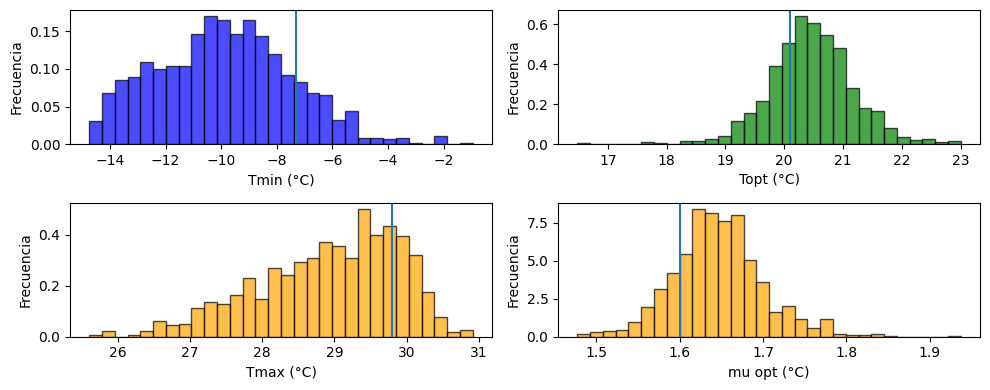

In [106]:
#HISTOGRAMAS

# 6. Crear histogramas para los parámetros
plt.figure(figsize=(10, 4))

# Histograma de alpha
plt.subplot(2, 2, 1)
plt.axvline(-7.3)
plt.hist(Tmin_samples, bins=30, color='blue', edgecolor='k', alpha=0.7, density=True)
plt.xlabel('Tmin (°C)')
plt.ylabel('Frecuencia')

# Histograma de beta
plt.subplot(2, 2, 2)
plt.hist(Topt_samples, bins=30, color='green', edgecolor='k', alpha=0.7, density=True)
plt.axvline(20.1)
plt.xlabel('Topt (°C)')
plt.ylabel('Frecuencia')

# Histograma de sigma
plt.subplot(2, 2, 3)
plt.hist(Tmax_samples, bins=30, color='orange', edgecolor='k', alpha=0.7, density=True)
plt.axvline(29.8)
plt.xlabel('Tmax (°C)')
plt.ylabel('Frecuencia')

# Histograma de sigma
plt.subplot(2, 2, 4)
plt.hist(mu_opt_samples, bins=30, color='orange', edgecolor='k', alpha=0.7, density=True)
plt.axvline(1.6)
plt.xlabel('mu opt (°C)')
plt.ylabel('Frecuencia')

# Ajustar el diseño de los subgráficos
plt.tight_layout()

# Mostrar los histogramas
plt.show()

array([[<Axes: title={'center': 'Tmax'}>,
        <Axes: title={'center': 'Tmax'}>],
       [<Axes: title={'center': 'Tmin'}>,
        <Axes: title={'center': 'Tmin'}>],
       [<Axes: title={'center': 'Topt'}>,
        <Axes: title={'center': 'Topt'}>],
       [<Axes: title={'center': 'mu_opt'}>,
        <Axes: title={'center': 'mu_opt'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

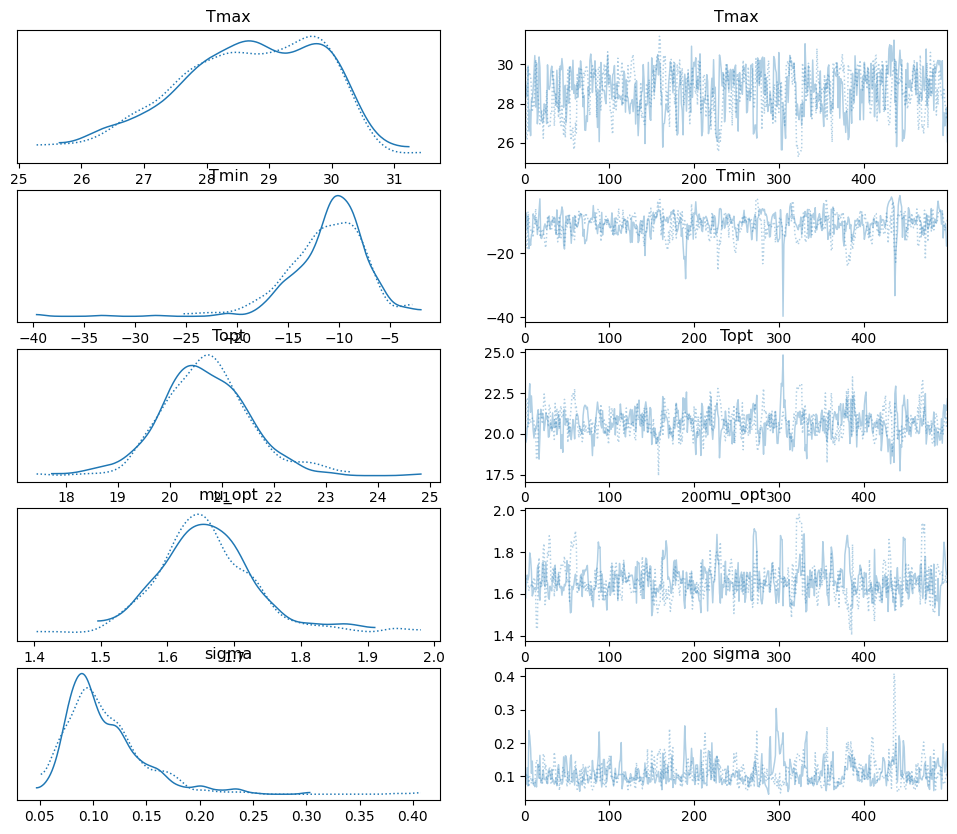

In [99]:
#az.summary(trace)
#pm.model_to_graphviz(model)
#az.plot_pair(trace)
#az.plot_posterior(trace)
az.plot_trace(trace)
